In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import rbf_kernel
import seaborn as sns
sns.set_theme()
from KSC import KSC

### Fix covariates and assignment

In [2]:
# one-dimensional example (d = 1)
# units
N = 500
N_c = int(0.6*N)    # 300 control units
N_t = N - N_c    # 200 treated units

# covariates = unifrom from [0, 1]
np.random.seed(0)
X = np.random.random_sample(N)

# sort the covariate values
X = np.sort(X)

# complete randomization
id = np.random.permutation(N)
id_t = id[:N_t]
id_c = id[N_t:]
id_t = np.sort(id_t)
id_c = np.sort(id_c)

# covariates of the treated and control units (sorted as well)
X_t = X[id_t]
X_c = X[id_c]

# Gaussian quantile
alpha = 0.05
q_norm = norm.ppf(1-alpha/2)

# RBF kernel
Consider the RBF kernel $k(x, x') = \exp(-\gamma |x - x'|^2)$ for $x, x' \in \mathbb{R}$. Assume $f_0(x) = k(\beta, x) = \exp(-\gamma |x - \beta|^2)$ for some $\beta \in [0, 1]$. Then, $\|f_0\| = \sqrt{k(\beta, \beta)} = 1$. Recall that
$$
\begin{split}
    \|\phi_{x_j} - \sum_{i \in \mathcal{C}} \hat{p}_{i j} \phi_{x_i}\|^2
    & = k(x_j, x_j) + \sum_{i, i' \in \mathcal{C}} \hat{p}_{i j} \hat{p}_{i' j} k(x_i, x_{i'}) - 2 \sum_{i \in \mathcal{C}} \hat{p}_{i j} k(x_i, x_j) \\
    & = (K_t)_{j j} + (\hat{p}^T K_c \hat{p})_{j j} - 2 (\hat{p}^T K_{c t})_{j j}.
\end{split}
$$

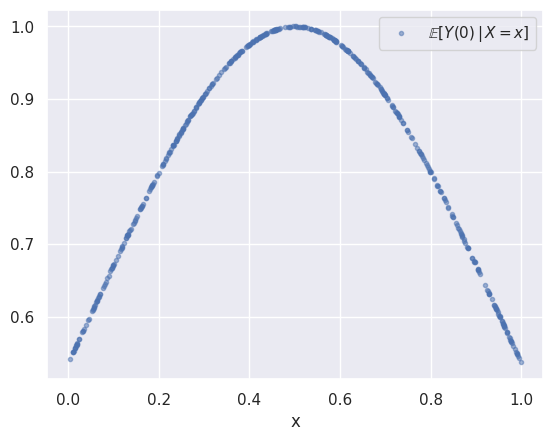

In [3]:
# conditional expectations of potential outcomes
# E[Y(0) | X = x] = exp(-gamma*|x-0.5|^2)
gamma = 2.5
CE_Y0 = np.exp(-gamma*(X-0.5)**2)
f0_norm = 1.0

plt.scatter(X, CE_Y0, marker='.', alpha=0.5, label=r'$\mathbb{E}[Y(0) \, | \, X = x]$')
plt.legend()
plt.xlabel('x')
plt.show()

CE_Y0_t = CE_Y0[id_t]
CE_Y0_c = CE_Y0[id_c]

Optimization

In [4]:
# kernel matrices
K_c = rbf_kernel(X_c[:,np.newaxis], gamma=gamma)  # (N_c, N_c)
K_ct = rbf_kernel(X_c[:,np.newaxis], X_t[:,np.newaxis], gamma=gamma)  # (N_c, N_t)
K_t = rbf_kernel(X_t[:,np.newaxis], gamma=gamma)  # (N_t, N_t)

l_range = np.array([0.1, 0.01, 0.001])
# PI_rbf = np.zeros((len(l_range), N_c, N_t)) # store couplings

# # solve the optimization problems
# for i, l in enumerate(l_range):

#     prob = KSC(Kcc=K_c, Kct=K_ct, Ktt=K_t, l=l)

#     if l > 0.001:
#         pi = prob.solve(method='gdkl', tau_scale=100, verbose=True)
        
#     else: 
#         pi = prob.solve(method='gdkl', tau_scale=500, verbose=True)

#     print('\n')

#     PI_rbf[i,:,:] = pi

# # save 
# np.save('results/CI_PI_rbf.npy', PI_rbf)

Initialization: objective = -1.0462881582245227
Implement gradient descent with KL divergence
Iteration 1: objective = -1.0713950697282435, objective relative change = -0.023996172857700556, pi change (L1) = 0.09713074773075829
Iteration 2: objective = -1.0893587073564033, objective relative change = -0.01676658604814768, pi change (L1) = 0.08195643083405271
Iteration 3: objective = -1.101996474875449, objective relative change = -0.011601107544928256, pi change (L1) = 0.06817931623158098
Iteration 4: objective = -1.110896402881667, objective relative change = -0.008076185549707843, pi change (L1) = 0.05662631749611348
Iteration 5: objective = -1.117227565034258, objective relative change = -0.0056991472257610625, pi change (L1) = 0.04726162059792352
Iteration 6: objective = -1.1217938775334722, objective relative change = -0.004087182094432223, pi change (L1) = 0.03974952425096152
Iteration 7: objective = -1.1251358012906802, objective relative change = -0.0029790889611165505, pi chan

In [5]:
# load the saved results
PI_rbf = np.load('results/CI_PI_rbf.npy')

# approximation errors
apprx_err = np.zeros((len(l_range), N_t))
for id_l in range(len(l_range)):

    pi = PI_rbf[id_l,:,:]
    p = N_t * pi
    apprx_err[id_l,:] = np.sqrt(np.diag(K_t) + np.diag(p.T @ K_c @ p) - 2.0 * np.diag(p.T @ K_ct))

Simulation

In [6]:
# simulation: vary the noise level and generate the residuals
s_range = np.array([0.1, 1.0, 3.0])

B = 1000

# # proposed confidence intervals
# U_hat = np.zeros((len(l_range), len(s_range), B, N_t))
# L_hat = np.zeros((len(l_range), len(s_range), B, N_t))

# # oracle confidence intervals
# U_o = np.zeros((len(l_range), len(s_range), B, N_t))
# L_o = np.zeros((len(l_range), len(s_range), B, N_t))

# # imputed potential outcomes
# Y_hat = np.zeros((len(l_range), len(s_range), B, N_t))

# f0_norm_estimates = np.zeros((len(s_range), B))
# s_estimates = np.zeros((len(s_range), B))

# ridge_rho = 10.0

# for id_s, s in enumerate(s_range):

#     for b in range(B):
#         # noise
#         eps = s*np.random.randn(N)

#         # potential outcomes 
#         Y0 = CE_Y0 + eps

#         # Y(0) is observed for control units
#         Y_c = Y0[id_c]

#         # kernel ridge regression
#         alpha_hat = np.linalg.pinv(K_c + np.eye(N_c)*ridge_rho) @ Y_c
#         Y_c_fit = K_c @ alpha_hat
#         f0_norm_hat = np.sqrt(np.dot(alpha_hat, Y_c_fit))
#         krr_res = Y_c - Y_c_fit
#         s_hat = np.std(krr_res, ddof=0)

#         f0_norm_estimates[id_s,b] = f0_norm_hat
#         s_estimates[id_s,b] = s_hat

#         # estimate and contruct intervals
#         for id_l in range(len(l_range)):

#             pi = PI_rbf[id_l,:,:]
#             p = N_t * pi

#             # estimate potential outcomes of treated units
#             Y_hat_0 = Y_c @ p
#             Y_hat[id_l,id_s,b,:] = Y_hat_0

#             # oracle confidence intervals
#             p_ss = np.sqrt(np.sum(p**2, axis=0))
#             variance_oracle = q_norm * s * p_ss
#             bias_oracle = CE_Y0_c @ p - CE_Y0_t
#             L_o[id_l,id_s,b,:] = Y_hat_0 - bias_oracle - variance_oracle
#             U_o[id_l,id_s,b,:] = Y_hat_0 - bias_oracle + variance_oracle

#             # proposed
#             variance_term = q_norm * s_hat * p_ss
#             bias_term = f0_norm_hat * apprx_err[id_l,:]
#             L_hat[id_l,id_s,b,:] = Y_hat_0 - bias_term - variance_term
#             U_hat[id_l,id_s,b,:] = Y_hat_0 + bias_term + variance_term


# np.save('results/CI_L_hat.npy', L_hat)
# np.save('results/CI_U_hat.npy', U_hat)

# np.save('results/CI_L_o.npy', L_o)
# np.save('results/CI_U_o.npy', U_o)

# np.save('results/CI_Y_hat.npy', Y_hat)

In [7]:
# load saved results
L_hat = np.load('results/CI_L_hat.npy')
U_hat = np.load('results/CI_U_hat.npy')

L_o = np.load('results/CI_L_o.npy')
U_o = np.load('results/CI_U_o.npy')

Y_hat = np.load('results/CI_Y_hat.npy')

Plots

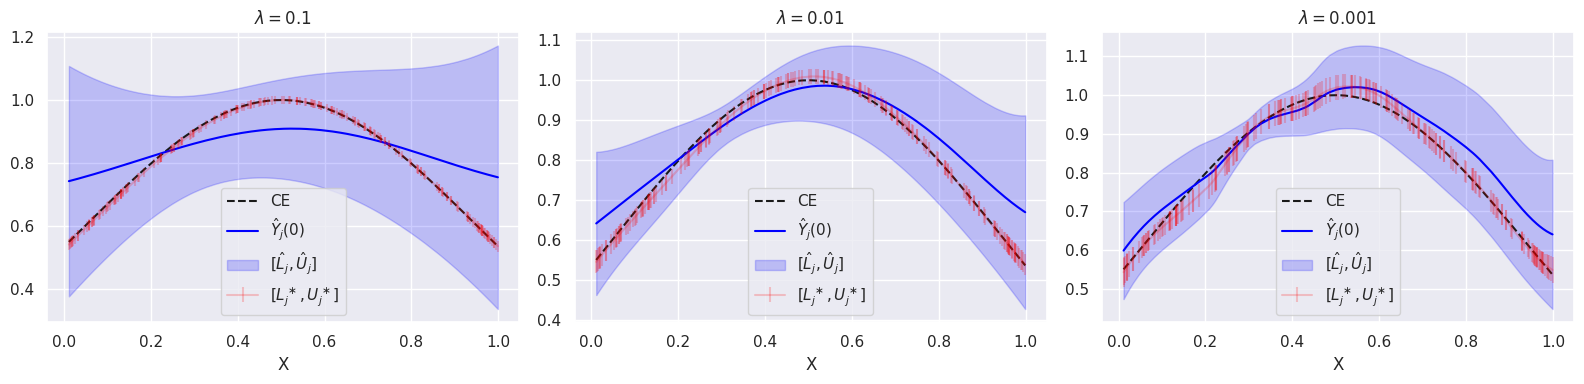

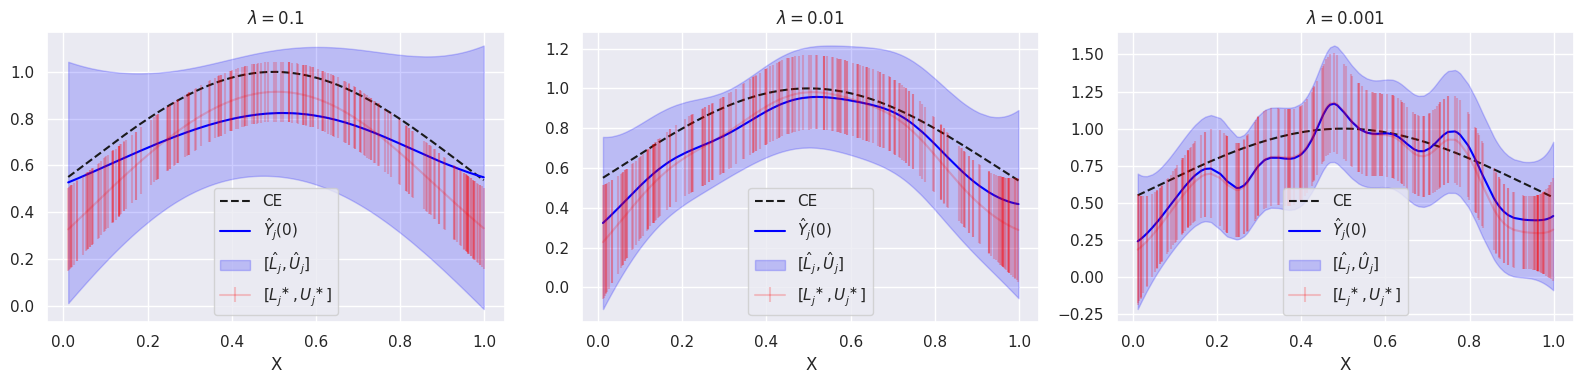

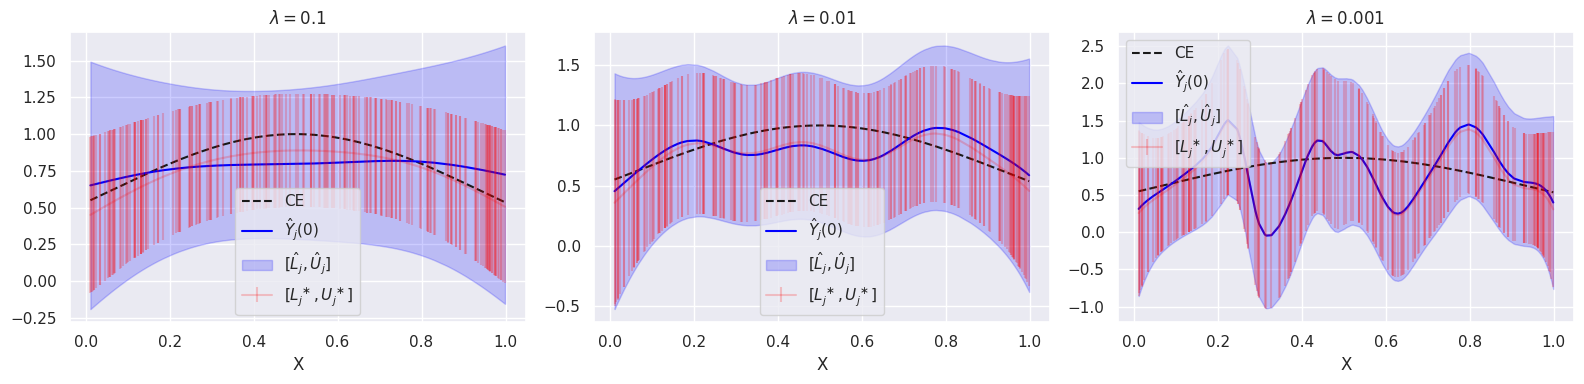

In [8]:
# for the b-th draw
b = 100
for id_s, s in enumerate(s_range):
    fig, axs = plt.subplots(1, len(l_range), figsize=(16, 4))
    for id_l, l in enumerate(l_range):
        axs[id_l].plot(X_t, CE_Y0_t, color='k', linestyle='dashed', label='CE')

        # proposed
        axs[id_l].plot(X_t, Y_hat[id_l,id_s,b,:], color='blue', label=r'$\hat{Y}_j(0)$')
        axs[id_l].fill_between(X_t, L_hat[id_l,id_s,b,:], U_hat[id_l,id_s,b,:], color='blue', alpha=0.2, label=r'$[\hat{L}_j, \hat{U}_j]$')

        # oracle
        radius = (U_o[id_l,id_s,b,:] - L_o[id_l,id_s,b,:])/2
        center = (U_o[id_l,id_s,b,:] + L_o[id_l,id_s,b,:])/2
        axs[id_l].errorbar(X_t, center, yerr=radius, color='red', alpha = 0.2, label=r'$[L_j^\ast, U_j^\ast]$')

        axs[id_l].legend()
        axs[id_l].set_xlabel('X')
        axs[id_l].set_title(f'$\lambda = {l}$')
    
    fig.tight_layout()
    plt.savefig('figs/CI' + f'{s}' + '.pdf')

Coverage

In [9]:
# check the coverage
coverage_oracle = np.zeros((len(l_range), len(s_range), N_t))
coverage_semi = np.zeros((len(l_range), len(s_range), N_t))
coverage_hat = np.zeros((len(l_range), len(s_range), N_t))
for id_s in range(len(s_range)):
    for id_l in range(len(l_range)):
        print(f'lambda = {l_range[id_l]}, sigma = {s_range[id_s]}')

        coverage_o = (L_o[id_l,id_s,:,:] < CE_Y0_t) & (U_o[id_l,id_s,:,:] > CE_Y0_t)
        coverage_oracle[id_l,id_s,:] = np.mean(coverage_o, axis=0)
        print('Oracle coverage')
        print(coverage_oracle[id_l,id_s,:])

        coverage_h = (L_hat[id_l,id_s,:,:] < CE_Y0_t) & (U_hat[id_l,id_s,:,:] > CE_Y0_t)
        coverage_hat[id_l,id_s,:] = np.mean(coverage_h, axis=0)
        print('Proposed coverage')
        print(coverage_hat[id_l,id_s,:])

        print('\n')

lambda = 0.1, sigma = 0.1
Oracle coverage
[0.943 0.944 0.943 0.943 0.943 0.943 0.942 0.943 0.941 0.941 0.943 0.944
 0.945 0.945 0.947 0.947 0.947 0.947 0.947 0.948 0.949 0.95  0.95  0.95
 0.95  0.951 0.95  0.949 0.949 0.948 0.947 0.949 0.949 0.949 0.949 0.949
 0.949 0.948 0.947 0.948 0.944 0.944 0.944 0.945 0.94  0.939 0.938 0.938
 0.937 0.937 0.936 0.937 0.937 0.937 0.937 0.94  0.94  0.94  0.942 0.942
 0.938 0.938 0.938 0.939 0.939 0.939 0.939 0.94  0.943 0.943 0.944 0.945
 0.945 0.944 0.945 0.945 0.945 0.948 0.948 0.948 0.948 0.949 0.95  0.949
 0.948 0.948 0.948 0.948 0.946 0.946 0.946 0.947 0.947 0.947 0.949 0.948
 0.945 0.945 0.947 0.947 0.951 0.951 0.951 0.95  0.95  0.951 0.951 0.951
 0.951 0.951 0.951 0.951 0.951 0.951 0.951 0.951 0.952 0.952 0.952 0.953
 0.953 0.954 0.954 0.954 0.954 0.954 0.953 0.954 0.953 0.953 0.953 0.955
 0.955 0.955 0.955 0.955 0.955 0.955 0.955 0.954 0.954 0.955 0.955 0.954
 0.953 0.955 0.955 0.956 0.957 0.96  0.959 0.959 0.96  0.96  0.96  0.96
 0.961 0.96

Plotting the coverage

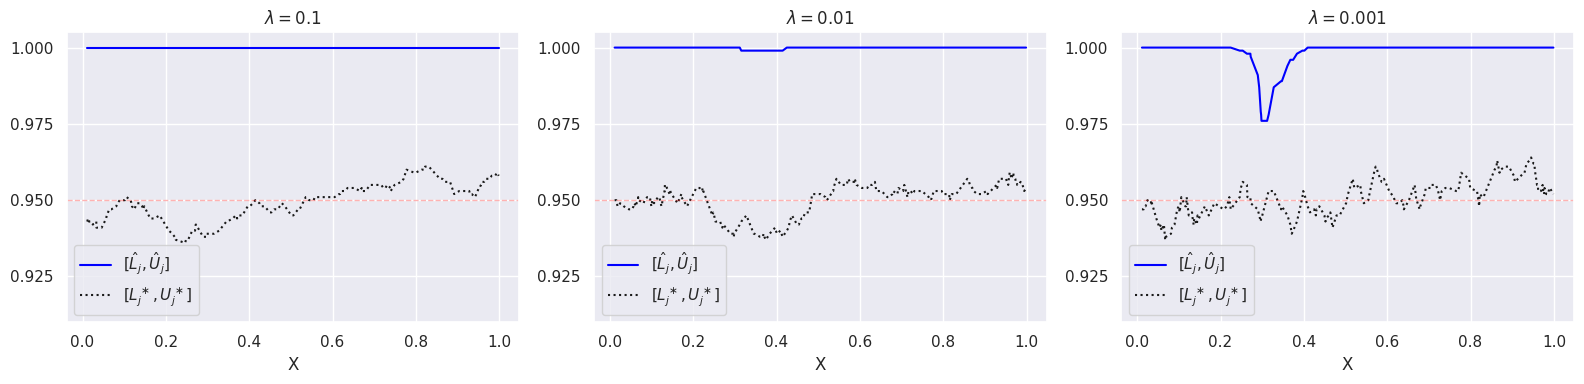

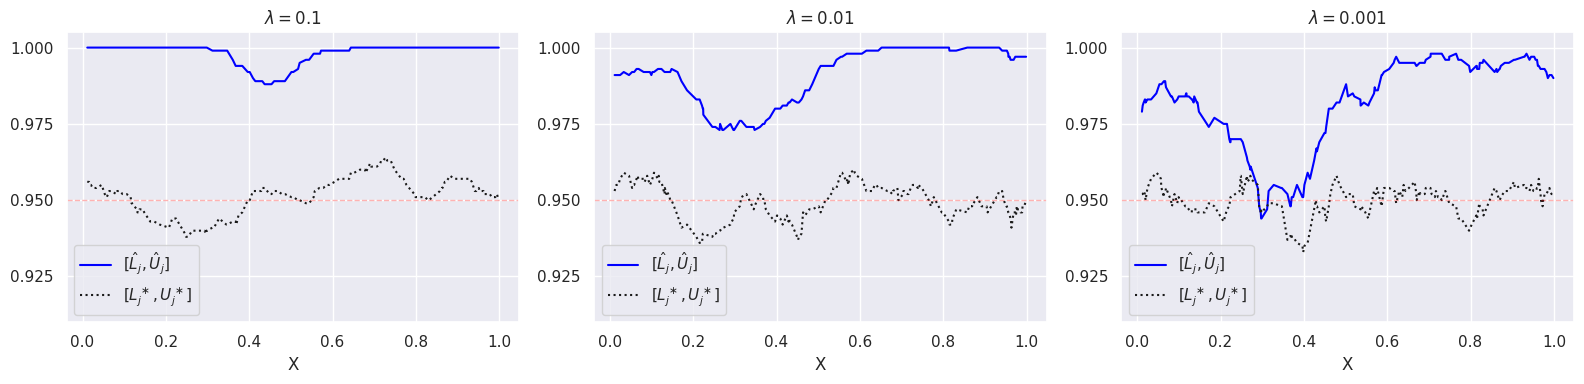

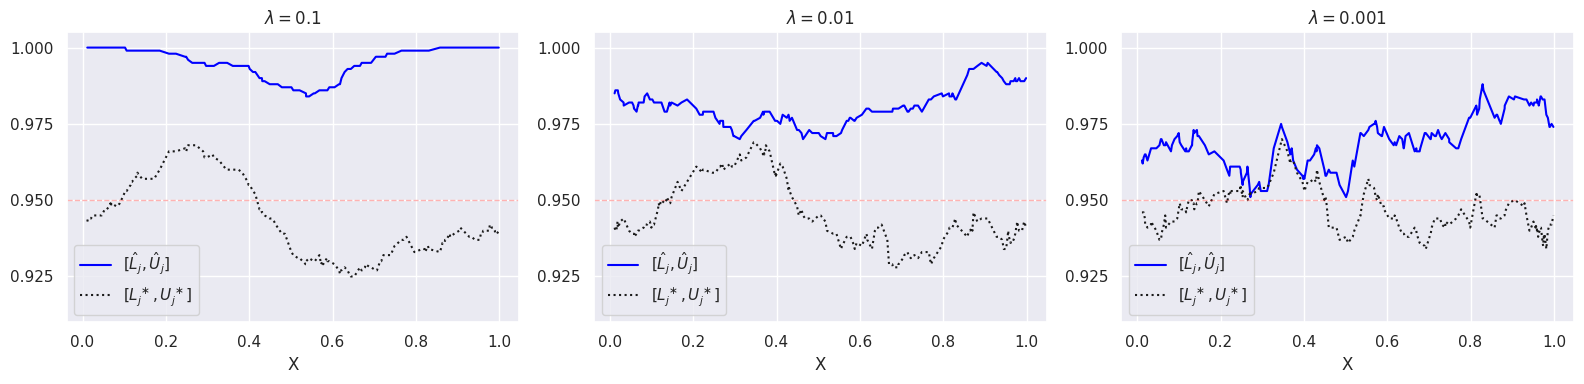

In [10]:
for id_s, s in enumerate(s_range):
    fig, axs = plt.subplots(1, len(l_range), figsize=(16, 4))
    for id_l, l in enumerate(l_range):
        cov_h = coverage_hat[id_l,id_s,:]
        axs[id_l].plot(X_t, cov_h, color='blue', linestyle='solid', label=r'$[\hat{L}_j, \hat{U}_j]$')

        cov_o = coverage_oracle[id_l,id_s,:]
        axs[id_l].plot(X_t, cov_o, color='k', linestyle='dotted', label=r'$[L_j^\ast, U_j^\ast]$')

        axs[id_l].axhline(y=0.95, color='red', linestyle='dashed', linewidth=1, alpha=0.3)
        axs[id_l].legend(loc=3)
        axs[id_l].set_xlabel('X')
        axs[id_l].set_ylim([0.91, 1.005])
        axs[id_l].set_title(f'$\lambda = {l}$')
        axs[id_l].set_yticks([0.925, 0.95, 0.975, 1.0])
    
    fig.tight_layout()
    plt.savefig('figs/CI_coverage' + f'{s}' + '.pdf')